In [220]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import t
from scipy.ndimage.filters import uniform_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

In [2]:
log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

In [9]:
# moving averages of different time span
def mov_avg(A, B, window_length=60):
    # Input: two 1440 x 1 numpy arrays
    # Output: two 288 x 1 numpy arrays
    
    pr_avg = uniform_filter1d(A, size=window_length, mode='nearest')[::30]
    vo_avg = uniform_filter1d(B, size=window_length, mode='nearest')[::30]

    return pr_avg[-10:], vo_avg[-5:]

In [10]:
def MACD(A):
    # Input: 1440 x 1 DataFrame
    # Output: two 1440 x 1 numpy array
    df = np.exp(A)
        
    # Get the 26-day EMA of the closing price
    k = df.ewm(span=26, adjust=False, min_periods=26).mean()
    # Get the 12-day EMA of the closing price
    d = df.ewm(span=12, adjust=False, min_periods=12).mean()

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = np.array(macd.ewm(span=9, adjust=False, min_periods=9).mean())

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    #macd_h = macd - macd_s
    
    return np.array(macd), macd_s #, macd_h

In [79]:
def np_ewma_vectorized(data, window):

    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1 / pows[:-1]
    offset = data[0] * pows[1:]
    pw0 = alpha * alpha_rev**(n-1)

    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out


def MACD(A):
    # Input: 1440 x 1 DataFrame
    # Output: two 1440 x 1 numpy array
    A = np.exp(A)
        
    # Get the 26-day EMA of the closing price
    k = np_ewma_vectorized(A, 26)
    # Get the 12-day EMA of the closing price
    d = np_ewma_vectorized(A, 12)

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    #Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = np.array(np_ewma_vectorized(macd, 9))

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    #macd_h = macd - macd_s
    
    return k, d, np.array(macd)#, macd_s#, macd_h

In [12]:
A = log_pr.iloc[20000:21440:30,0]
k, d, macd1, macd2 = MACD(A)
plt.plot(A)
#plt.plot(k)
#plt.plot(d)

ValueError: not enough values to unpack (expected 4, got 3)

In [13]:
plt.plot(k)
plt.plot(d)

NameError: name 'k' is not defined

In [191]:
def RSI_np(A, window_length=14, method="WMS"):
    """
    Calculate RSI
    A: numpy array of log price
    method : "SMA": simple moving average,
            "WMS": Wilder Smoothing Method,
            "EMA": exponential moving average
    
    Return RSI for last three periods
    """
    # transform log-price to price
    A = np.exp(A)
    tmp = np.diff(A)

    gain = np.clip(tmp, a_min = 0, a_max = None)
    loss = np.abs(np.clip(tmp, a_min = None, a_max = 0))

    if method == "WMS":
        avg_gain = np_ewma_vectorized(gain, window_length)#[-10:]
        avg_loss = np_ewma_vectorized(loss, window_length)#[-10:]
    else:
        avg_gain = np_ewma_vectorized(gain, window_length)#[-10:]
        avg_loss = np_ewma_vectorized(loss, window_length)#[-10:]
    
    #rs = avg_gain / avg_loss
    rsi = 100 - (100 * avg_loss / (avg_loss + avg_gain))
    return rsi[-1]-rsi[-2]

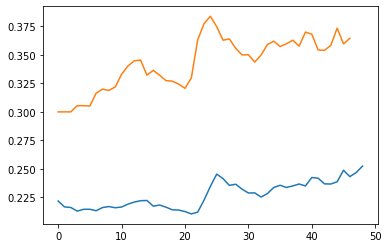

In [170]:
A = log_pr.iloc[1440*139:(1440*140+30):30,3]
#rsi = RSI_np(A)
plt.plot(A.values)
plt.plot(rsi / 1000 + 0.3)

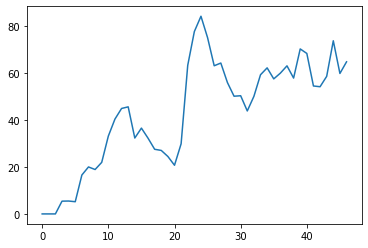

In [168]:
plt.plot(rsi)

In [169]:
np.corrcoef((A[1:].values - A[:-1].values), rsi)


array([[1.       , 0.3899643],
       [0.3899643, 1.       ]])

In [17]:
def volChanges(B, window_length=30):
    vol0 = np.mean(B[-30:])
    vol1 = np.mean(B[-60:-30])
    vol2 = np.mean(B[-90:-60])
    vol3 = np.mean(B[-120:-90])
    vol4 = np.mean(B[-180:-120])
    
    return np.array([vol3-vol4, vol2-vol3, vol1-vol2, vol0-vol1, vol0])

In [18]:
def getVolRatios(vol, volWindow=[10, 30, 60]):  
    # Input: 1440 x 1 numpy array
    # the window here is in minutes
    # Output: 3 dim numpy array
    
    return np.array([sum(vol[-win:]) for win in volWindow]) / sum(vol)

In [19]:
def priceVolCor(A, B, time=[1440, 720, 360]):
    # Input: two 1440 x 1 numpy arrays
    # Output: 3 dim numpy array
    
    pv_cor = A
    temp = np.hstack((A, B))
    pv_cor = [np.corrcoef(temp[-t:]) for t in time]
    return np.array(pv_cor)

In [226]:
# z-score of log-price
def zScorePr(A):
    # Input: 1440 x 1 numpy array
    # Output: 3 dim numpy array
    # the moving average log-price of 30min, 1h, and 3h
    
    # moving averages of 30 minutes
    pr_avg_0 = uniform_filter1d(A, size=30, mode='nearest')
    print(pr_avg_0, A[-1])
    
    # 1 hour (60 minutes)
    pr_avg_1 = uniform_filter1d(A, size=60, mode='nearest')
    
    # 2 hour (120 minutes)
    pr_avg_2 = uniform_filter1d(A, size=120, mode='nearest')
    
    # 3 hours (180 minutes)
    pr_avg_3 = uniform_filter1d(A, size=180, mode='nearest')
    
    z0 = (A[-1] - pr_avg_0[-1]) / np.std(pr_avg_0)
    z1 = (A[-1] - pr_avg_1[-1]) / np.std(pr_avg_1)
    z2 = (A[-1] - pr_avg_2[-1]) / np.std(pr_avg_2)
    z3 = (A[-1] - pr_avg_3[-1]) / np.std(pr_avg_3)
    return np.array([z0, z1, z2, z3])

In [232]:
uniform_filter1d([2., 8., 0., 4., 1., 8., 9., 0.], size=4, mode='nearest')

array([3.5 , 3.  , 3.5 , 3.25, 3.25, 5.5 , 4.5 , 4.25])

In [4]:
def neg30logr(A):
    return -(A[-1] - A[-30])

In [222]:
def get_features(A, B):
    m1, m2 = mov_avg(A, B)
    macd1, _, macd = MACD(A[::30])
    #print(len(m1), len(m2))
    #print(len(macd1), len(macd))
    #print(np.shape(RSI_np(A[::30])))
    return np.hstack((
        #m1, m2,
        #macd1, macd,
        #RSI_np(A[::30]),
        #volChanges(B),
        #getVolRatios(B),
        #priceVolCor(A, B),
        zScorePr(A),
        neg30logr(A)
    )).reshape((1, -1))

In [227]:
f = get_features(log_pr.iloc[:1440,0], volu.iloc[:1440,0])
p = np.shape(f)
print(len(log_pr.iloc[0:1440,0]), f)

[-0.00031745 -0.00036686 -0.00041043 ... -0.01276805 -0.01279274
 -0.01282182] -0.013185678398132474
1440 [[-0.07032783 -0.07556241 -0.1013895  -0.11950342  0.00156663]]


In [218]:

test_res = []
selected_rank2 = []

ytest = []
pred = []

for asset in range(10):
    t0 = time.time()
    
    fs = get_features(log_pr.iloc[:1440, asset], volu.iloc[:1440, asset])
    y = log_pr.iloc[1440+29, asset] - log_pr.iloc[1440-1, asset]
    
    d = 10

    for t in range(1440*140 - 30)[d::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((y, log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]))

    #t_used = time.time() - t0
    #print(t_used, np.shape(fs), np.shape(y))
    
    ftest = get_features(log_pr.iloc[10:1450, asset], volu.iloc[10:1450, asset])
    ytest.append(log_pr.iloc[1450+29, asset] - log_pr.iloc[1450-1, asset])
    
    d = 10

    for t in range(264960-1470)[- 1440*40::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        ftest = np.vstack((ftest, f))
        ytest.append(log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset])
    
    t_used = time.time() - t0
    print(t_used, np.shape(ftest), np.shape(ytest))
    
    model = LinearRegression()
    model.fit(fs, y)

    pred.append(model.predict(ftest))
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])
    #with open('./model_{}.pkl'.format(asset),'wb') as f:
    #    pickle.dump(model,f)
    
    #select = RFE(model, n_features_to_select=40, step=1).fit(fs, y)
    #selected.append([i for i in range(p) if select.support_[i]])
    #selected_rank2.append(select.ranking_)

49.02937602996826 (5761, 124) (5761,)
49.289610147476196 (5761, 124) (11522,)
49.583842039108276 (5761, 124) (17283,)
49.998798847198486 (5761, 124) (23044,)
49.80769157409668 (5761, 124) (28805,)
49.708346128463745 (5761, 124) (34566,)
49.53101110458374 (5761, 124) (40327,)
50.53310489654541 (5761, 124) (46088,)
50.23157596588135 (5761, 124) (51849,)
50.877293825149536 (5761, 124) (57610,)


In [219]:
print(np.shape(fs), np.shape(y))
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))

(20157, 124) (20157, 1)


array([[1.        , 0.03850146],
       [0.03850146, 1.        ]])

In [ ]:
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))[0,1]
# volchange + volratio + zscore + neg 30 log return
0.043

In [ ]:
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))[0,1]
# volchange + zscore + neg 30 log return
0.04774884

In [203]:
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))[0,1]
# volchange + neg 30 log return

0.043513578177361206

In [186]:
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))[0,1]
# only neg 30 log return

0.033666411192918584

In [143]:
np.savetxt('rank5.csv', np.array(selected_rank2).astype(int), delimiter=",")

In [34]:
# train the models for submission
selected = []
selected_rank = []

for asset in range(10):
    t0 = time.time()

    fs = get_features(log_pr.iloc[14400:(1440 * 11), asset], volu.iloc[14400:(1440 * 11), asset])
    y = np.mean(log_pr.iloc[(1440 * 11+27):(1440 * 11+33), asset])

    '''
    d = 10

    for t in range(1440 * 0, 1440 * 60, d): 
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            np.mean(log_pr.iloc[(t+1440+27):(t+1440+33), asset])
        ))
'''
    d = 10

    for t in range(1440 * 60, 264960 - 1470, d): # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            np.mean(log_pr.iloc[(t+1440+27):(t+1440+33), asset])
        ))
    
    t_used = time.time() - t0
    print(t_used, np.shape(fs), np.shape(y))
    
    model = LinearRegression()
    model.fit(fs, y)

    #pred = model.predict(ftest)
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])
    with open('./model_{}.pkl'.format(asset),'wb') as f:
        pickle.dump(model,f)
    
    select = RFE(model, n_features_to_select=100, step=2).fit(fs, y)
    selected.append([i for i in range(p) if select.support_[i]])
    selected_rank.append(select.ranking_)

24.14228582382202 (17710, 54) (17710, 1)
23.785460948944092 (17710, 54) (17710, 1)
23.681946992874146 (17710, 54) (17710, 1)
23.733747959136963 (17710, 54) (17710, 1)
23.906121969223022 (17710, 54) (17710, 1)
23.739688873291016 (17710, 54) (17710, 1)
23.616945266723633 (17710, 54) (17710, 1)
23.680667877197266 (17710, 54) (17710, 1)
23.42979097366333 (17710, 54) (17710, 1)
23.85346508026123 (17710, 54) (17710, 1)


In [176]:
test = []
MODELS = []
for i in range(0,10):
    with open('model_{}.pkl'.format(i), 'rb') as f:
        model = pickle.load(f)
        MODELS.append(model)

for asset in range(10):
    predicts = []
    ytest = []

    d = 10

    for t in range(264960-1470)[- 1440*60+5::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        ytest.append(log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset])
        
        pred = MODELS[asset].predict(f) - log_pr.iloc[t+1440-1, asset]
        predicts.append(pred)

    test.append(np.corrcoef(
        np.array(predicts).reshape((1,-1)), 
        np.array(ytest).reshape(1,-1)
    )[0,1])

In [177]:
sum(test) / 10

0.08906513161874165

In [178]:
test

[0.05552181175117214,
 0.12847399421691935,
 0.07896424414989169,
 0.03742755167751043,
 0.17606325016316782,
 0.08454616419995781,
 0.0699229650306859,
 0.025679004415454634,
 0.13893199839422718,
 0.09512033218842937]